# Fake news Detection using NLP
Author: Karuna Gujar

This project distinguishes between fake and real news. FOllowign are the details about the expmeriment performed:

1. Pre-processing data: conversion to lower case, removal of punctuation and removal of stopwords.
2. The dataset was split into train and test using a ratio of 0.8:0.2.
3. Data cleaned by removing URLs, Twitter handles, news source and location, uni-grams 'Donald' and 'Trump'
3. Features used: Bag of words, Word2vec, TF-IDF
3. Features were generated using enrichment and noenrichment as described below:
    •Enrichment => Word enrichment was performed by computing odds-ratio using the following formula :Top 1000 uni-grams with highest odds ratio of observation in fake vs real articles were used.  Similarly, top 1000 uni-grams with highest odds ratio of observation in real vs fake articles were selected. Features were then generated for the enriched words using the above mentioned natural language processingmethods.
    •No Enrichment => In the second approach, no enrichment was performed and all words were used for generating features using the above mentioned natural language processing methods.
4. Classfiers: Naive Bayes, Logistic Regression
5. Evaluation metrics: Accuracy, precision, recall, F-measure, AUC

In [1]:
#Fake - 23482
#True - 21418

import csv
import random
import string
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk import (precision,recall)
from nltk.corpus import stopwords
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk import pos_tag
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import preprocessing
import csv
import random
import string
import collections
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk import (precision,recall)
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import pandas as pd
import pickle
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from nltk import pos_tag
from nltk.corpus import opinion_lexicon
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn import preprocessing

train_test_ratio = 0.8
test_train_div = 0.2
#lemmatizing
lemmatizer = WordNetLemmatizer()

# Pre-processing the data

In [2]:
#collects stopwords
stop_words = set(stopwords.words('english'))

news_source = {'reuters', 'getty', 'images', 'http', 'https',"donald","trump"}
#Preprocess data- remove puctuation from words, remove stopwords, lemmatize and lower case
def tokenize_and_preproces(x):
    tokens = word_tokenize(x)
    cleaned_tokens = []
    for each_token in tokens:
        tmp = each_token.lower()
        if tmp in news_source:
            continue
     
        #drop stopwords
        if(tmp.isalpha() and tmp not in stop_words):
            #stemming
            tmp = lemmatizer.lemmatize(tmp)
            cleaned_tokens.append(tmp)

    return cleaned_tokens

# Reading the input CSV files

In [3]:
import re


#Read input file and split into train and test dataframes
def read_input_file():
    news = []
    category = []
    all_words = []
    all_words_fake = []
    all_words_true = []

    #cleaning data to remove peculiar patterns
    #remove URL, twitter handler, News source and location
    url_regex=re.compile(r"(?:www|https|http?)[^\s]+")
    twitter_handle1 = re.compile(r"\s([@#][\w_-]+)")
    twitter_handle2 = re.compile(r"\(([@#][\w_-]+)[\)]+")
    remove_last = re.compile(r"(\.|\?)([^\.]+)(\.$|$)")
    source_match = re.compile(r"^([^-]+)-")



    with open("Fake.csv", "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for lines in csv_reader:
            
            tmp1 = re.sub(url_regex,'',lines[1])
            tmp1 = re.sub(twitter_handle1,'',tmp1)
            tmp1 = re.sub(twitter_handle2,'',tmp1)
            tmp1 = re.sub(remove_last,'',tmp1)

            category.append('Fake')
            clean_tokens = tokenize_and_preproces(tmp1)
            news.append(clean_tokens)
            all_words.extend(clean_tokens)
            all_words_fake.extend(clean_tokens)


    with open("True.csv", "r") as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        next(csv_reader)
        for lines in csv_reader:
            tmp1 = re.sub(url_regex,'',lines[1])
            tmp1 = re.sub(twitter_handle1,'',tmp1)
            tmp1 = re.sub(twitter_handle2,'',tmp1)
            tmp1 = re.sub(source_match,'',tmp1)

            category.append('True')
            clean_tokens = tokenize_and_preproces(tmp1)
            news.append(clean_tokens)
            all_words.extend(clean_tokens)
            all_words_true.extend(clean_tokens)

    df_news = pd.DataFrame({'label':category, 'news':news})
    df_news = shuffle(df_news)

    Y = df_news.loc[:,'label'].values
    X = df_news.loc[:,'news'].values

    train_x, test_x, train_y, test_y = train_test_split(X,Y , test_size=test_train_div, random_state=0, stratify=Y)
    
    train_df = pd.DataFrame({'label':train_y, 'news':train_x})
    test_df = pd.DataFrame({'label':test_y, 'news':test_x})
    
    words = {"all_words":all_words,"all_words_fake":all_words_fake,"all_words_true":all_words_true}
    
    return train_df, test_df, words


train_df, test_df, words = read_input_file()

train_df

,label,news
0,Fake,"[seems, rather, unpopular, workforce, answer, ..."
1,Fake,"[girl, smacked, saturday, huffington, post, in..."
2,Fake,"[appeared, fox, friend, monday, morning, blame..."
3,True,"[house, representative, would, override, presi..."
4,True,"[canada, indigenous, population, growing, four..."
...,...,...
35913,True,"[linda, liau, work, precision, master, peering..."
35914,Fake,"[story, likely, find, anywhere, else, politica..."
35915,Fake,"[bernie, sander, picked, one, important, endor..."
35916,Fake,"[patrick, henningsen, century, wirewhat, mille..."


In [4]:
import pickle
#Store the processed data in the form of python object
train_df.to_pickle("train.df")
test_df.to_pickle("test.df")
test_df.to_pickle("test.df")
with open('words.pickle', 'wb') as handle:
    pickle.dump(words, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [5]:
train_df = pd.read_pickle("train.df")
test_df = pd.read_pickle("test.df")
with open('words.pickle', 'rb') as handle:
    words = pickle.load(handle)


In [6]:
#frequency distribution of all words
allWords = nltk.FreqDist(words["all_words"])

#frequency distribution of words in fake news
allWordsFake = nltk.FreqDist(words["all_words_fake"])

#frequency distribution of words in true news
allWordsTrue = nltk.FreqDist(words["all_words_true"])

# Bag of words -no enrichment

In [7]:
#features used: top 2000 most frequent words
word_features_top = list(allWords.keys())[:2000]
def find_features(document):
    words = set(document)
    features = {}
    for w in word_features_top:
        features[w] = (w in words)

    return features

train_df["top_count"] = train_df.news.apply(lambda x:find_features(x))
test_df["top_count"] = test_df.news.apply(lambda x:find_features(x))

train_df=train_df.sample(frac=1)


In [8]:
training_set=list(zip(train_df.top_count.values.tolist(),train_df.label.values.tolist()))
test_Set=list(zip(test_df.top_count.values.tolist(),test_df.label.values.tolist()))

  
classifier = nltk.NaiveBayesClassifier.train(training_set)


refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(test_Set):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)
    
print('****************************************************')
print(' Features: Bag Of Words- All words')
print(' Classifier: Naive Bayes')
print('****************************************************')
print('Accuracy: ',nltk.classify.accuracy(classifier, test_Set))

print('Precision for Fake news: ',nltk.precision(refsets['Fake'], testsets['Fake']))
print('Recall for Fake news: ', nltk.recall(refsets['Fake'], testsets['Fake']))
print('F-measure for Fake news: ',nltk.f_measure(refsets['Fake'], testsets['Fake']))

print('\n')
print('Precision for True news: ',nltk.precision(refsets['True'], testsets['True']))
print('Recall for True news: ',nltk.recall(refsets['True'], testsets['True']))
print('F-measure for True news: ',nltk.f_measure(refsets['True'], testsets['True']))

print('****************************************************')


****************************************************
 Features: Bag Of Words- All words
 Classifier: Naive Bayes
****************************************************
Accuracy:  0.8832962138084632
Precision for Fake news:  0.92998585572843
Recall for Fake news:  0.840076660988075
F-measure for Fake news:  0.8827478183038712


Precision for True news:  0.8414943013929929
Recall for True news:  0.930672268907563
F-measure for True news:  0.8838395034360452
****************************************************


# Bag of enriched words 

In [9]:
dict_fake={}
dict_true={}
fake_length = len(train_df[train_df.label=="Fake"])+len(test_df[test_df.label=="Fake"])
true_length = len(train_df[train_df.label=="True"])+len(test_df[test_df.label=="True"])
log_ratio={}

#word should appear more than 5 times
for item in allWordsFake.items():
    if item[1] > 5:
        #normalizing the counts (on average how many times the word occurs in one document)
        dict_fake[item[0]]=(item[1]+1)/(fake_length+1)
for item in allWordsTrue.items():
    if item[1] > 5:
        dict_true[item[0]]=(item[1]+1)/(true_length+1)

#finding words which occur in Fake and not in True and the count atleast 5 or more
for item in allWordsTrue.items():
    if item not in dict_fake and item[1] > 5:
        dict_fake[item[0]]=1/(fake_length+1)
        
#finding words which occur in True and not in Fake and the count is atleast more than 5
for item in allWordsFake.items():
    if item not in dict_true and item[1] > 5:
        dict_true[item[0]]=1/(true_length+1)
        
for key,value in dict_true.items():
    log_ratio[key] = np.log(value/dict_fake.get(key))

sorted_keys = [k for k, v in sorted(log_ratio.items(), key=lambda item: item[1])]
word_features = sorted_keys[0:1000]+sorted_keys[-1000:]

word_features

['quot',
 'bundy',
 'acr',
 'filessupport',
 'antifa',
 'amp',
 'subscribe',
 'shit',
 'hilarious',
 'tapper',
 'var',
 'henningsen',
 'cdata',
 'fjs',
 'finicum',
 'ny',
 'bullshit',
 'tantrum',
 'subscribing',
 'illegals',
 'dyer',
 'neocon',
 'hesher',
 'uh',
 'pst',
 'uncensored',
 'pissed',
 'uninterruptible',
 'evangelist',
 'damning',
 'creepy',
 'savant',
 'moralist',
 'spore',
 'lovable',
 'nypd',
 'lemon',
 'masochist',
 'fucking',
 'stephanopoulos',
 'helton',
 'keefe',
 'agitator',
 'lol',
 'whined',
 'aka',
 'veritas',
 'brag',
 'ammon',
 'mic',
 'shady',
 'asshole',
 'whine',
 'behar',
 'misogynistic',
 'beyonc',
 'sane',
 'nowicki',
 'msm',
 'dept',
 'malheur',
 'lahren',
 'reddit',
 'ramsey',
 'crony',
 'trumpcare',
 'streep',
 'fortunately',
 'bolling',
 'interestingly',
 'lavoy',
 'dude',
 'mandalay',
 'cliven',
 'epstein',
 'sgt',
 'idiotic',
 'ya',
 'trayvon',
 'gitmo',
 'screenshot',
 'amateur',
 'clueless',
 'affleck',
 'antic',
 'busted',
 'camerota',
 'snowflake

In [10]:
def get_features(document,word_feats):
    words = set(document)
    features = {}
    for w in word_feats:
        features[w] = (w in words)
    return features

train_df["vec_nb"] = train_df.news.apply(lambda x:get_features(x,word_features))
test_df["vec_nb"] = test_df.news.apply(lambda x:get_features(x,word_features))

train_df=train_df.sample(frac=1)


train_df

,label,news,top_count,vec_nb
4005,Fake,"[decade, hillary, clinton, claimed, back, mari...","{'wish': False, 'american': False, 'happy': Fa...","{'quot': False, 'bundy': False, 'acr': False, ..."
12798,True,"[united, state, remains, committed, libyan, po...","{'wish': False, 'american': False, 'happy': Fa...","{'quot': False, 'bundy': False, 'acr': False, ..."
21128,True,"[president, intends, nominate, kevin, hassett,...","{'wish': False, 'american': True, 'happy': Fal...","{'quot': False, 'bundy': False, 'acr': False, ..."
25618,Fake,"[broke, biggest, promise, supporter, bigly, sp...","{'wish': False, 'american': True, 'happy': Fal...","{'quot': False, 'bundy': False, 'acr': False, ..."
32009,Fake,"[president, obama, finally, vindicated, seven,...","{'wish': False, 'american': True, 'happy': Fal...","{'quot': False, 'bundy': False, 'acr': False, ..."
...,...,...,...,...
6869,Fake,"[atmosphere, created, conservative, witch, hun...","{'wish': False, 'american': True, 'happy': Tru...","{'quot': False, 'bundy': False, 'acr': False, ..."
7619,True,"[administration, defensive, investigation, all...","{'wish': False, 'american': False, 'happy': Fa...","{'quot': False, 'bundy': False, 'acr': False, ..."
29698,Fake,"[remember, comedian, funny, good, ole, day, ca...","{'wish': False, 'american': False, 'happy': Fa...","{'quot': False, 'bundy': False, 'acr': False, ..."
28255,Fake,"[patriotic, university, missouri, student, bur...","{'wish': False, 'american': True, 'happy': Fal...","{'quot': False, 'bundy': False, 'acr': False, ..."


In [11]:
training_set=list(zip(train_df.vec_nb.values.tolist(),train_df.label.values.tolist()))
test_Set=list(zip(test_df.vec_nb.values.tolist(),test_df.label.values.tolist()))

    
classifier = nltk.NaiveBayesClassifier.train(training_set)


refsets = collections.defaultdict(set)
testsets = collections.defaultdict(set)

for i, (feats, label) in enumerate(test_Set):
    refsets[label].add(i)
    observed = classifier.classify(feats)
    testsets[observed].add(i)


    
print('****************************************************')
print(' Features: Bag of enriched words')
print(' Classifier: Naive Bayes')
print('****************************************************')
print('Accuracy: ',nltk.classify.accuracy(classifier, test_Set))

print('Precision for Fake news: ',nltk.precision(refsets['Fake'], testsets['Fake']))
print('Recall for Fake news: ', nltk.recall(refsets['Fake'], testsets['Fake']))
print('F-measure for Fake news: ',nltk.f_measure(refsets['Fake'], testsets['Fake']))

print('\n')
print('Precision for True news: ',nltk.precision(refsets['True'], testsets['True']))
print('Recall for True news: ',nltk.recall(refsets['True'], testsets['True']))
print('F-measure for True news: ',nltk.f_measure(refsets['True'], testsets['True']))

print('****************************************************')




****************************************************
 Features: Bag of enriched words
 Classifier: Naive Bayes
****************************************************
Accuracy:  0.8082405345211582
Precision for Fake news:  0.9457434052757794
Recall for Fake news:  0.6718483816013628
F-measure for Fake news:  0.7856075697211156


Precision for True news:  0.726966690290574
Recall for True news:  0.957749766573296
F-measure for True news:  0.8265511684125706
****************************************************


In [12]:
#This function calculates and displays the ROC (Receiver Operating Characteristic curve)
def calculateROC(testy, testX, model):
    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(testy))]

    # predict probabilities
    lr_probs = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('\n No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Logistic: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs, pos_label='True')
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs, pos_label='True')
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()

# GloVe vectorization of all words - no enrichment

In [13]:

#GloVe
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
filename = 'glove.6B.50d.word2vec'
glove_input_file = 'glove.6B.50d.txt' 
word2vec_output_file = 'glove.6B.50d.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

model = KeyedVectors.load_word2vec_format(filename, binary=False)

#This function gives the vector representation, using GLoVe, for the given list of words
def get_vector(x, word_features_cur=None):
    tmp = np.zeros(50)
    #tmp1=list(set(x).intersection(word_features_cur))
    for word in x:
        if word_features_cur is not None and word not in word_features_cur:
            continue
        try:
            tmp = np.add(tmp,model[word])
        except:
            continue  
    return tmp

#getting vector form of all words using GloVe
train_df["unigrams_vec_all"] = train_df.news.apply(lambda x:get_vector(x))
test_df["unigrams_vec_all"] = test_df.news.apply(lambda x:get_vector(x))
Y_all = train_df.label.values
X_all = train_df.unigrams_vec_all.values.tolist()

ytest = test_df.label.values
xtest = test_df.unigrams_vec_all.values.tolist()

****************************************************
 Feature: GloVe vectorization of all words
 Classifier: Logistic Regression
****************************************************
ovr Accuracy:  0.9148106904231625
ovr Classification Report: 
               precision    recall  f1-score   support

        Fake       0.92      0.91      0.92      4696
        True       0.91      0.92      0.91      4284

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980

ovr Classification Report: 
 [[4294  402]
 [ 363 3921]]

 No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.959


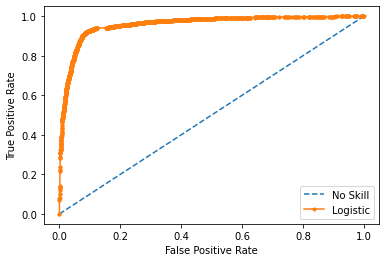

****************************************************


In [14]:

#Feeding the GolVe vectorized form of all words to the Logistic Regression
mclass='ovr'
lr = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.01,
                        random_state=0, multi_class=mclass, \
                        dual=False,penalty="l2",class_weight="balanced").fit(X_all, Y_all)
yhat = lr.predict(xtest)

print('****************************************************')
print(' Feature: GloVe vectorization of all words')
print(' Classifier: Logistic Regression')
print('****************************************************')

print(mclass,'Accuracy: ',accuracy_score(ytest, yhat))
print(mclass,'Classification Report: \n',classification_report(ytest, yhat))
print(mclass,'Classification Report: \n',confusion_matrix(ytest, yhat))
      
calculateROC(ytest, xtest, lr)
print('****************************************************')


# GloVe vectorization of  enriched words

In [15]:
#getting vector form of enriched words using GloVe
train_df["unigrams_vec"] = train_df.news.apply(lambda x:get_vector(x,word_features))
test_df["unigrams_vec"] = test_df.news.apply(lambda x:get_vector(x,word_features))
Y = train_df.label.values
X = train_df.unigrams_vec.values.tolist()

ytest = test_df.label.values
xtest = test_df.unigrams_vec.values.tolist()

****************************************************
 Feature: GloVe vectorization of enriched words
 Classifier: Logistic Regression
****************************************************
ovr Accuracy:  0.7657015590200446
ovr Classification Report: 
               precision    recall  f1-score   support

        Fake       0.91      0.61      0.73      4696
        True       0.69      0.94      0.79      4284

    accuracy                           0.77      8980
   macro avg       0.80      0.77      0.76      8980
weighted avg       0.80      0.77      0.76      8980

ovr Classification Report: 
 [[2869 1827]
 [ 277 4007]]

 No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.806


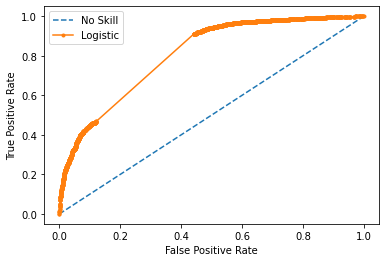

****************************************************


In [16]:
#Feeding the GolVe vectorized form of enriched words to the Logistic Regression
mclass='ovr'
lr2 = LogisticRegression(solver='lbfgs', max_iter=1000, C=0.01,
   
                         random_state=0, multi_class=mclass, \
                        dual=False,penalty="l2",class_weight="balanced").fit(X, Y)
yhat = lr2.predict(xtest)

print('****************************************************')
print(' Feature: GloVe vectorization of enriched words')
print(' Classifier: Logistic Regression')
print('****************************************************')

print(mclass,'Accuracy: ',accuracy_score(ytest, yhat))
print(mclass,'Classification Report: \n',classification_report(ytest, yhat))
print(mclass,'Classification Report: \n',confusion_matrix(ytest, yhat))
      
calculateROC(ytest, xtest, lr)
print('****************************************************')

In [17]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
#TF-IDF vectorized form of enriched words 

train_df["cleaned_txt"]=train_df.apply(lambda x: ' '.join([word for word in x.news if word in word_features]),axis=1)

test_df["cleaned_txt"]=test_df.apply(lambda x: ' '.join([word for word in x.news if word in word_features]),axis=1)

In [19]:
#TF-IDF vectorized form of all the words
train_df["cleaned_txt_all"]=train_df.apply(lambda x: ' '.join([word for word in x.news]),axis=1)

test_df["cleaned_txt_all"]=test_df.apply(lambda x: ' '.join([word for word in x.news]),axis=1)

# TF-IDF vectorization of all the words - no enrichment

****************************************************
 Feature: TF-IDF of all words
 Classifier: Logistic Regression
****************************************************
ovr Accuracy:  0.9328507795100223
ovr Classification Report: 
               precision    recall  f1-score   support

        Fake       0.94      0.93      0.94      4696
        True       0.93      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

ovr Classification Report: 
 [[4372  324]
 [ 279 4005]]

 No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.979


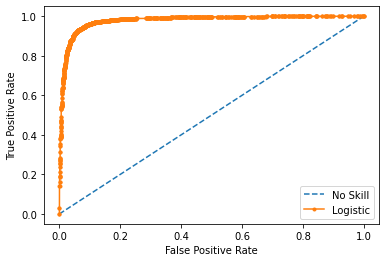

****************************************************


In [20]:
#calling the TfidfVectorizer
vectorize_all= TfidfVectorizer()

#Feeding the TF-IDF vectorized form of all the words to the Logistic Regression
response_all= vectorize_all.fit_transform(train_df.cleaned_txt_all.values.tolist())

response_t_all = vectorize_all.transform(test_df.cleaned_txt_all.values.tolist())

lr = LogisticRegression(solver='lbfgs', max_iter=100, C=0.01,
                        random_state=0, multi_class=mclass, \
                        dual=False,penalty="l2",class_weight="balanced").fit(response_all, train_df.label.values.tolist())
yhat = lr.predict(response_t_all)

print('****************************************************')
print(' Feature: TF-IDF of all words')
print(' Classifier: Logistic Regression')
print('****************************************************')
      
print(mclass,'Accuracy: ',accuracy_score(test_df.label.values.tolist(), yhat))
print(mclass,'Classification Report: \n',classification_report(ytest, yhat))
print(mclass,'Classification Report: \n',confusion_matrix(ytest, yhat))
      
calculateROC(ytest, response_t_all, lr)
print('****************************************************')

# TF-IDF vectorization of enriched words

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

#calling the TfidfVectorizer
vectorize= TfidfVectorizer()

#fitting the model and passing enriched words:
response= vectorize.fit_transform(train_df.cleaned_txt.values.tolist())

response_t = vectorize.transform(test_df.cleaned_txt.values.tolist())

****************************************************
 Feature: TF-IDF of enriched words
 Classifier: Logistic Regression
****************************************************
ovr Accuracy:  0.8052338530066815
ovr Classification Report: 
               precision    recall  f1-score   support

        Fake       0.95      0.66      0.78      4696
        True       0.72      0.96      0.83      4284

    accuracy                           0.81      8980
   macro avg       0.84      0.81      0.80      8980
weighted avg       0.84      0.81      0.80      8980

ovr Classification Report: 
 [[3103 1593]
 [ 156 4128]]

 No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.904


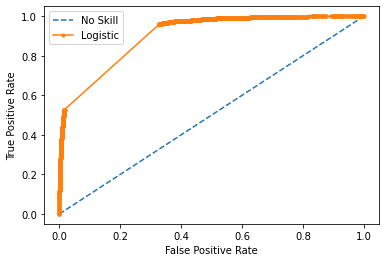

****************************************************


In [22]:
#Feeding the TF-IDF vectorized form of enriched words to the Logistic Regression classifier
lr = LogisticRegression(solver='lbfgs', max_iter=100, C=0.01,
                        random_state=0, multi_class=mclass, \
                        dual=False,penalty="l2",class_weight="balanced").fit(response, train_df.label.values.tolist())
yhat = lr.predict(response_t)

print('****************************************************')
print(' Feature: TF-IDF of enriched words')
print(' Classifier: Logistic Regression')
print('****************************************************')

print(mclass,'Accuracy: ',accuracy_score(test_df.label.values.tolist(), yhat))
print(mclass,'Classification Report: \n',classification_report(ytest, yhat))
print(mclass,'Classification Report: \n',confusion_matrix(ytest, yhat))

calculateROC(ytest, response_t, lr)
print('****************************************************')